# Train Queryable Input Classifier
This notebook trains an LSTM model that classifies whether the user's input can be queryable, in that the model should extract keywords to look online via the citation fetcher class.

In [41]:
from datasets import Dataset, DatasetDict
from matplotlib import pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn import metrics
from torchtext import data, datasets

import const
import datasets
import pandas as pd
import numpy as np
import torchtext
import torch
import torch.nn as nn
import random
import spacy
import subprocess

In [42]:
TEXT = data.Field(tokenize="spacy", tokenizer_language="en_core_web_sm")

In [43]:
LABEL = data.LabelField(dtype= torch.long)

In [44]:
TRAINING_DS_PATH = const.DATASETS_FOLDER + "QI_training.csv"
TESTING_DS_PATH = const.DATASETS_FOLDER + "QI_testing.csv"

FEATURE_COL = "question"
LABEL_COL = "is_searchable"

In [45]:
TRAIN_SPLIT = 0.7

# MODEL PARAMETERS
CORPUS_SIZE = 25000
LEARNING_RATE = 1e-3
BATCH_SIZE = 128
EPOCHS = 50

EMBEDDING_DIM = 256
HIDDEN_DIM = 512
OUTPUT_DIM = 2
DEVICE = "auto"

In [85]:
MODEL_NAME = "aletheianomous_ai-QI_class-v0.1.4" 
MODEL_SAVE_PATH = (const.MODELS_FOLDER + MODEL_NAME + "/"
       + "model.pt")
VOCAB_SAVE_PATH = (const.MODELS_FOLDER + MODEL_NAME + "/vocab.pt")
LABEL_VOCAB_PATH = (const.MODELS_FOLDER + MODEL_NAME + "/label_vocab.pt")

In [47]:
if DEVICE == "auto":
    if torch.cuda.is_available():
        selected_device = "cuda"
    else:
        selected_device = "cpu"
else:
    selected_device = DEVICE

In [48]:
selected_device

'cuda'

In [49]:
training_df = pd.read_csv(TRAINING_DS_PATH)
testing_df = pd.read_csv(TESTING_DS_PATH)

/tmp/ipykernel_486373/2416222827.py:1: DtypeWarning: Columns (2,3,4,6,7,8,9,14) have mixed types. Specify dtype option on import or set low_memory=False.
  training_df = pd.read_csv(TRAINING_DS_PATH)


In [50]:
len(training_df)

204726

In [51]:
split_ind = int(len(training_df) * TRAIN_SPLIT)
training_df = training_df.sample(frac=1)
training_df = training_df.reset_index()

validation_df = training_df[split_ind:]
validation_df = validation_df.reset_index()
training_df = training_df[0:split_ind]

In [52]:
len(training_df)

143308

In [53]:
len(validation_df)

61418

In [54]:
training_df.tail()

,index,Unnamed: 0.4,Unnamed: 0,source,topic,paragraph,question,question_id,is_impossible,answers,expanded_answers,is_searchable,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,data
143303,130798,130798,479.0,NaN,NaN,NaN,How can renewable energy be integrated into ex...,NaN,NaN,NaN,NaN,1.0,479.0,479.0,479.0,['How can renewable energy be integrated into ...
143304,120476,120476,120476.0,Squad 2.0,Red,Red is the traditional color of warning and da...,What is a football player shown before being e...,57314bf3497a881900248d7d,False,a red penalty card,"s of motoring, motor cars had to follow a man ...",1.0,NaN,NaN,NaN,NaN
143305,187439,187439,NaN,NaN,NaN,NaN,hahaha good for you ! :D \nwhat are u studying..?,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
143306,28392,28392,28392.0,Squad 2.0,Computer,One means by which this is done is with a spec...,A signal that stops a compute executing instru...,56fdfb9219033b140034ce22,False,"an interrupt,",can return to that task later. If several pro...,1.0,NaN,NaN,NaN,NaN
143307,114492,114492,114492.0,Squad 2.0,Liberia,"Liberia is divided into fifteen counties, whic...",What counties were the first to be founded aft...,5a62b298f8d794001af1c1c4,True,Grand Bassa and Montserrado,"nty, created in 2001. Nimba is the largest of ...",1.0,NaN,NaN,NaN,NaN


In [55]:
validation_df.tail()

,level_0,index,Unnamed: 0.4,Unnamed: 0,source,topic,paragraph,question,question_id,is_impossible,answers,expanded_answers,is_searchable,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,data
61413,204721,14221,14221,14221.0,Squad 2.0,Alexander_Graham_Bell,The 150th anniversary of Bell's birth in 1997 ...,In what year did Canada put out a coin to comm...,56dfc400231d4119001abdbd,False,2009,r: users of the telephone over the ages; an au...,1.0,NaN,NaN,NaN,NaN
61414,204722,10736,10736,10736.0,Squad 2.0,Human_Development_Index,Some countries were not included for various r...,What is the main reason that countries were ex...,5ad0cd5f645df0001a2d03dc,True,lack of necessary data,and Tuvalu.,1.0,NaN,NaN,NaN,NaN
61415,204723,3832,3832,3832.0,Squad 2.0,New_York_City,New York City has a high degree of income disp...,"In 2014, millionaires made up what percentage ...",56cf39b4aab44d1400b88eb3,False,4.6%,"In the first quarter of 2014, the average week...",1.0,NaN,NaN,NaN,NaN
61416,204724,149946,149946,19627.0,NaN,NaN,NaN,Can you find me information on the use of geod...,NaN,NaN,NaN,NaN,1.0,19627.0,19627.0,19627.0,['Can you find me information on the use of ge...
61417,204725,157411,157411,27092.0,NaN,NaN,NaN,Can you recommend some scenic drives to take i...,NaN,NaN,NaN,NaN,1.0,27092.0,27092.0,27092.0,['Can you recommend some scenic drives to take...


In [16]:
validation_df.to_csv(const.DATASETS_FOLDER + "QI_validation.csv")

In [56]:
torch.backends.cudnn.deterministic=True

In [57]:
labels = training_df[LABEL_COL].unique()

In [58]:
weights = compute_class_weight(class_weight="balanced", classes=labels, y=training_df[LABEL_COL].to_numpy())

In [59]:
loss_weights = torch.Tensor(weights)
#loss_weights = None

In [60]:
testing_df.columns

Index(['Unnamed: 0.4', 'Unnamed: 0', 'source', 'topic', 'paragraph',
       'question', 'question_id', 'is_impossible', 'answers',
       'expanded_answers', 'is_searchable', 'Unnamed: 0.3', 'Unnamed: 0.2',
       'Unnamed: 0.1', 'data'],
      dtype='object')

In [61]:
training_df.columns

Index(['index', 'Unnamed: 0.4', 'Unnamed: 0', 'source', 'topic', 'paragraph',
       'question', 'question_id', 'is_impossible', 'answers',
       'expanded_answers', 'is_searchable', 'Unnamed: 0.3', 'Unnamed: 0.2',
       'Unnamed: 0.1', 'data'],
      dtype='object')

In [62]:
testing_df.head()

,Unnamed: 0.4,Unnamed: 0,source,topic,paragraph,question,question_id,is_impossible,answers,expanded_answers,is_searchable,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,data
0,0,0.0,Squad 2.0,Normans,The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,56ddde6b9a695914005b9628,False,France,"and and Norway who, under their leader Rollo, ...",1.0,NaN,NaN,NaN,NaN
1,1,1.0,Squad 2.0,Normans,The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,56ddde6b9a695914005b9628,False,France,"and and Norway who, under their leader Rollo, ...",1.0,NaN,NaN,NaN,NaN
2,2,2.0,Squad 2.0,Normans,The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,56ddde6b9a695914005b9628,False,France,"and and Norway who, under their leader Rollo, ...",1.0,NaN,NaN,NaN,NaN
3,3,3.0,Squad 2.0,Normans,The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,56ddde6b9a695914005b9628,False,France,"and and Norway who, under their leader Rollo, ...",1.0,NaN,NaN,NaN,NaN
4,4,4.0,Squad 2.0,Normans,The Normans (Norman: Nourmands; French: Norman...,When were the Normans in Normandy?,56ddde6b9a695914005b9629,False,10th and 11th centuries,"and and Norway who, under their leader Rollo, ...",1.0,NaN,NaN,NaN,NaN


In [63]:
TEXT = data.Field(tokenize='spacy', tokenizer_language = "en_core_web_sm")
LABEL = data.LabelField(dtype = torch.float)

fields = {
    FEATURE_COL: (FEATURE_COL, TEXT),
    LABEL_COL: (LABEL_COL, LABEL)
}

In [64]:
training_ds, val_ds, testing_ds= data.TabularDataset.splits(
    path = const.DATASETS_FOLDER,
    train = "QI_training.csv",
    validation = "QI_validation.csv",
    test = "QI_testing.csv",
    format = 'csv',
    fields = fields
)

print(vars(training_ds[0]))

{'question': ['When', 'did', 'Beyonce', 'start', 'becoming', 'popular', '?'], 'is_searchable': '1.0'}


In [65]:
TEXT.build_vocab(training_ds, max_size=CORPUS_SIZE)
LABEL.build_vocab(training_ds)

In [66]:
training_dl, val_dl, testing_dl = data.BucketIterator.splits(
    (training_ds, val_ds, testing_ds),
    batch_size=BATCH_SIZE,
    device=selected_device,
    sort=False
)

In [67]:
class QIClassifier(nn.Module):
    
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=2,
              batch_first=False)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, text):
        embedded_text = self.embedding(text)
        output, hidden = self.rnn(embedded_text)
        logits = self.fc(output[-1, :, :])
        output = self.softmax(logits)
        return logits, output
        

In [29]:
def train(model, training_ds, validation_ds=None, epochs=10, class_weights=None, device="cpu", epoch_timestamp=1, lr=0.001):
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    epoch_modulus: int
    model.train()
    model = model.to(device)
    if class_weights is not None:
        class_weights = class_weights.to(device)
    if device == "cuda":
        loss = nn.CrossEntropyLoss(weight=class_weights).cuda()
    else:
        loss = nn.CrossEntropyLoss(weight=class_weights)

    ds_ls = {"training": training_ds, "validation": validation_ds}
    
    for i in range(epochs):            
        epoch_modulus = i % epoch_timestamp
        for phase in ds_ls.keys():
            ds = ds_ls[phase]
            
            if ds is None:
                print("Skipping validation")
                continue
            
            if phase == "training":
                model.train()
            elif phase == "validation":
                model.eval()
                
            for batch_id, batch_data in enumerate(ds):
                logits, out = model(batch_data.question.to(device))
                logits = logits.to(device)
                if phase == "training":
                    optimizer.zero_grad()
                label = batch_data.is_searchable.to(device)
                cost = loss(logits, label.to(torch.long))
                if phase == "training":
                    cost.backward()
                    optimizer.step()
                    cost = cost.cpu().item()
                elif phase == "validation":
                    cost = cost.cpu().item()
                    
                if epoch_timestamp == 1:
                    (print("Epoch " + str(i + 1) + "/" + str(epochs) + 
                           " " + phase + " loss: " + str(cost), 
                           end="                                \r"))
                elif epoch_timestamp > 1:
                    if epoch_modulus == epoch_timestamp - 1:
                        end_line = "\n"
                    else:
                        end_line = "                        \r"
                    print("Epoch " + str(i + 1) + "/" + str(epochs) + " " + phase +  " loss: " + str(cost), end=end_line)
                else:
                    raise ValueError("Expected epoch_timestamp parameter to be a non-negative number but got " + str(epoch_timestamp))
            print()

In [ ]:
qi_classifier = QIClassifier(len(TEXT.vocab), EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

In [ ]:
train(qi_classifier, training_dl, validation_ds = val_dl, epochs=EPOCHS, class_weights=loss_weights, device=selected_device, lr=LEARNING_RATE)

In [ ]:
torch.save(qi_classifier, MODEL_SAVE_PATH)

In [ ]:
tokenizer = spacy.load("en_core_web_sm")

In [31]:
def predict(model, input_sentence, tokenizer):
    model.eval()
    token_sent = [tok.text for tok in tokenizer.tokenizer(input_sentence)]
    tok_index = [TEXT.vocab.stoi[t] for t in token_sent]
    tensor = torch.LongTensor(tok_index).to(selected_device)
    tensor = tensor.unsqueeze(1)
    logit, probas = model(tensor)
    output = torch.argmax(probas, dim=1)
    return probas.cpu(), output.cpu()

In [ ]:
probas, output = predict(qi_classifier, "Who is Beyonce's daughter?", tokenizer)

In [ ]:
output

In [ ]:
probas

# IMPORTANT
The model may have trained to classify non-searchable terms as 1
while searchable terms is classified as 0.

In [32]:
def calc_conf_matrix(outputs, labels):
    i: int = 0
    conf_matrix = pd.DataFrame(data={"true": [0,0], "false": [0,0]}, index=["true", "false"])
    conf_matr_row: int = 0
    conf_matr_col: int = 0
    if len(outputs) == len(labels):
        for i in range(len(outputs)):
            output = outputs[i]
            label = labels[i]
            if output == 0.0:
                conf_matr_row = 1
            elif output == 1.0:
                conf_matr_row = 0
            else:
                raise ValueError(output)

            if label == 0.0:
                conf_matr_col = 1
            elif label == 1.0:
                conf_matr_col = 0
            else:
                raise ValueError(output)

            conf_matrix.iloc[conf_matr_row, conf_matr_col] +=1
    else:
        raise AssertionError()
    return conf_matrix
        

In [76]:
def plot_roc(fpr, tpr, title="ROC Curve"):
    roc_auc = metrics.auc(fpr,tpr)
    plt.title(title)
    plt.plot(fpr, tpr, 'b', label= 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0,1], [0,1], 'r--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

In [79]:
def test_model(model, test_dl, device="cpu"):
    model = model.to(device)
    out_arr = np.array([])
    labels_arr = np.array([])
    ds_size: int = 0
    for batch_id, batch_data in enumerate(test_dl):
        label = batch_data.is_searchable.to(device)
        logits, proba = model(batch_data.question.to(device))
        ds_size += batch_data.is_searchable.size(0)
        out = torch.argmax(proba, dim=1)
        out_arr = np.append(out_arr, out.cpu().numpy())
        labels_arr = np.append(labels_arr, label.cpu().numpy())
    conf_matrix: pd.DataFrame = calc_conf_matrix(out_arr, labels_arr)
    precision: float = conf_matrix.iloc[0,0] / (conf_matrix.iloc[0,0] + conf_matrix.iloc[0,1])
    recall: float = conf_matrix.iloc[0,0] / (conf_matrix.iloc[0,0] + conf_matrix.iloc[1,0])
    accuracy: float = (conf_matrix.iloc[0,0] + conf_matrix.iloc[1,1]) / ds_size
    fpr, tpr, threshold = metrics.roc_curve(out_arr, labels_arr)
    return conf_matrix, precision, recall, accuracy, fpr, tpr

In [80]:
conf_matrix, precision, recall, accuracy, fpr, tpr = test_model(qi_classifier, testing_dl, device=selected_device)

In [81]:
conf_matrix

,true,false
true,16521,548
false,369,40684


In [82]:
print("Precision: ", (precision*100), "%")
print("Recall: ", (recall*100), "%")
print("Accuracy: ", (accuracy*100), "%")

Precision:  96.78950143535063 %
Recall:  97.81527531083482 %
Accuracy:  98.42228416090293 %


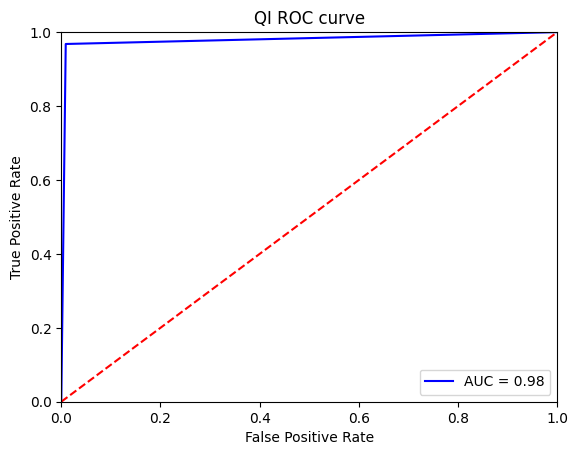

In [83]:
plot_roc(fpr, tpr, title="QI ROC curve")

In [84]:
torch.save(TEXT, VOCAB_SAVE_PATH)

In [86]:
torch.save(LABEL, LABEL_VOCAB_PATH)